# Binary Classification: Cat-Dog

With the main help of Tensorflow, I will create a small model that can classify images into one of two categories: **Cat** or **Dog**.

Each step are mage independant to be able to use them separately, except **Data Loading** and **Prediction**

In [1]:
import os, shutil, random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Data Fetching

Getting images from an online storage.

In [2]:
# dwonload the dataset
!wget "https://www.dropbox.com/s/h16vq9rab1itifs/CatDog.zip"

--2024-01-31 22:09:24--  https://www.dropbox.com/s/h16vq9rab1itifs/CatDog.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/h16vq9rab1itifs/CatDog.zip [following]
--2024-01-31 22:09:25--  https://www.dropbox.com/s/raw/h16vq9rab1itifs/CatDog.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd47678b6d2612d4e4821bd872a.dl.dropboxusercontent.com/cd/0/inline/CMaRNllbGmNX6uaKrKc7iWurLqXOET8rKwS3tLx5K_TRleTGg_m9ZnzTuDav08ZZFli2qAo5p5PvJk_rnsiIXhwmxoGq2rcueQOyghk--Tkx9UvIMFyjZqYZhV2XGCzy9xF2uLWVOheafkse1Su2r0oa/file# [following]
--2024-01-31 22:09:26--  https://ucd47678b6d2612d4e4821bd872a.dl.dropboxusercontent.com/cd/0/inline/CMaRNllbGmNX6uaKrKc7iWurLqXOET8rKwS3tLx5K_TRleTGg_m9ZnzTuDav08ZZFli2qAo5p5PvJk_rnsiIXhwmxoGq2rcueQOyghk--

In [3]:
!unzip CatDog.zip > /dev/null
!rm CatDog.zip

## Data Preparation

Reorganising images to be able to easily manipulate them later.

The training set will be divided into training and validation sets (default: 70-30), with a 50% chance for an image to be into validation.

In [4]:
test_dir = './test'

try: os.rename('./test_set', test_dir)
except: pass

for d in ['cats', 'dogs']:
  src_dir = os.path.join(test_dir, 'test_set', d)
  dst_dir = os.path.join(test_dir, d)

  if not os.path.exists(dst_dir): os.mkdir(dst_dir)

  for fname in os.listdir(src_dir):
    if fname == '_DS_Store': continue
    shutil.copyfile(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

shutil.rmtree(os.path.join(test_dir, 'test_set'))

In [5]:
train_dir = './train'
val_dir = './valid'

VALID_RATIO = 0.3
VALID_PROBA = 0.5

try:
  os.rename('./training_set', train_dir)
except:
  pass

if not os.path.exists(val_dir): os.mkdir(val_dir)

for d in ['cats', 'dogs']:
  print(d.upper(), '\n'+'-'*4)

  src_dir = os.path.join(train_dir, 'training_set', d)
  print('Source Size:', len(os.listdir(src_dir)))

  dst_train_dir = os.path.join(train_dir, d)
  dst_val_dir = os.path.join(val_dir, d)

  if not os.path.exists(dst_train_dir): os.mkdir(dst_train_dir)
  if not os.path.exists(dst_val_dir): os.mkdir(dst_val_dir)

  for fname in os.listdir(src_dir):
    if fname == '_DS_Store': continue
    for_val = (
        ((len(os.listdir(dst_val_dir))/len(os.listdir(src_dir))) < VALID_RATIO) and
        (random.random() < VALID_PROBA)
    )
    dst_dir = dst_val_dir if for_val else dst_train_dir

    f = os.path.join(src_dir, fname)
    shutil.copyfile(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

  print('Training Size:', len(os.listdir(dst_train_dir)), f'({round(len(os.listdir(dst_train_dir)) * 100 / len(os.listdir(src_dir)), 0)}%)')
  print('Validation Size:', len(os.listdir(dst_val_dir)), f'({round(len(os.listdir(dst_val_dir)) * 100 / len(os.listdir(src_dir)), 0)}%)')
  print('\n')

shutil.rmtree(os.path.join(train_dir, 'training_set'))

CATS 
----
Source Size: 4001
Training Size: 2799 (70.0%)
Validation Size: 1201 (30.0%)


DOGS 
----
Source Size: 4006
Training Size: 2803 (70.0%)
Validation Size: 1202 (30.0%)




## Data Loading

Here 70% the images are loaded and resize to 128x128, to use the memory just enough and garanty that the animals are still recognizable. The images are then shuffled to avoid overfitting and unexpected behavior.

The process is done for each training, testing, and validation sets.

In [6]:
CATEGORIES = ['cat', 'dog']
IMG_SIZE = (128, 128)
DATA_RATIO = .7 # the ratio of image to use (prevents memory overload)

def load_images(path, ratio=1):
  # path: the path that has 'cats' and 'dogs' folders
  files = []

  cats_dir = os.path.join(path, 'cats')
  if os.path.exists(cats_dir):
    cfiles = os.listdir(cats_dir)
    nfiles = int(len(cfiles) * DATA_RATIO)

    files += [(os.path.join(cats_dir, f), 0) for f in cfiles[:nfiles]]

  dogs_dir = os.path.join(path, 'dogs')
  if os.path.exists(dogs_dir):
    dfiles = os.listdir(dogs_dir)
    nfiles = int(len(dfiles) * DATA_RATIO)

    files += [(os.path.join(dogs_dir, f), 1) for f in dfiles[:nfiles]]

  random.shuffle(files)

  X, y = np.empty((len(files), *IMG_SIZE, 3)), np.empty(len(files), dtype=int)
  for i in range(len(files)):
      f, c = files[i]

      image = plt.imread(f)
      image = tf.image.resize_with_pad(image, *IMG_SIZE).numpy() / 255

      X[i] = image
      y[i] = c

  return X, y

def view_data(x, y):
  print('category:', CATEGORIES[y])

  plt.imshow(x)
  plt.tight_layout()
  plt.axis('off')
  plt.show()

shape: (3921, 128, 128, 3)
category: cat


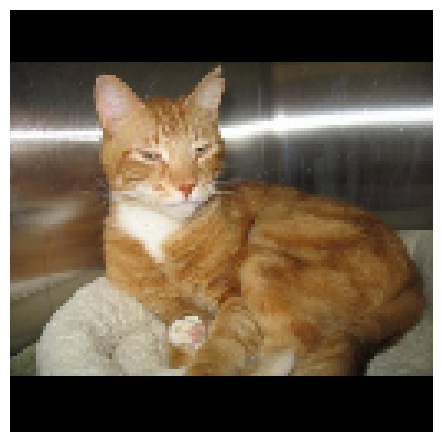

In [7]:
X_train, y_train = load_images('/content/train')
print('shape:', X_train.shape)
view_data(X_train[0], y_train[0])

shape: (1681, 128, 128, 3)
category: dog


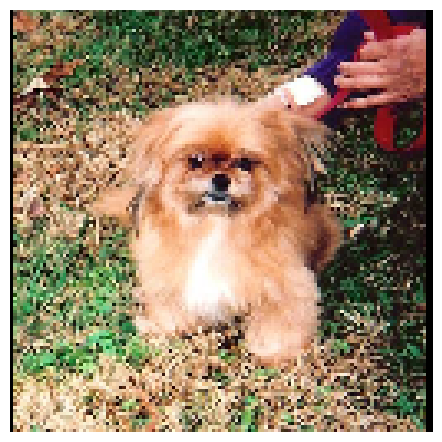

In [8]:
X_valid, y_valid = load_images('/content/valid')
print('shape:', X_valid.shape)
view_data(X_valid[0], y_valid[0])

shape: (1415, 128, 128, 3)
category: cat


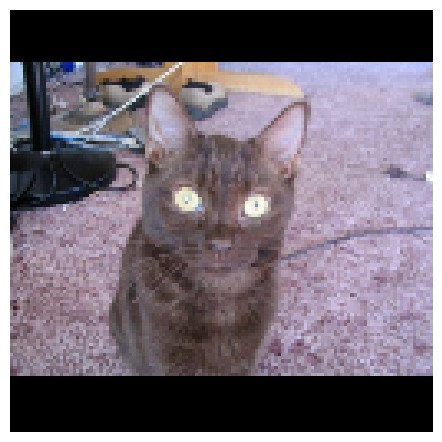

In [9]:
X_test, y_test = load_images('/content/test')
print('shape:', X_test.shape)
view_data(X_test[0], y_test[0])

## Training

This part uses images from the loading part to train and evaluate a CNN model.

In [10]:
inputs = keras.layers.Input(X_train[0].shape)

kernel_size = (2,2)
x = keras.layers.Conv2D(filters=10, kernel_size=kernel_size)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = keras.layers.MaxPooling2D(pool_size=kernel_size)(x)

kernel_size = (4,4)
x = keras.layers.Conv2D(filters=10, kernel_size=kernel_size)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = keras.layers.MaxPooling2D(pool_size=kernel_size)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256, use_bias=True)(x)
x = keras.activations.relu(x)
x = keras.layers.Dropout(rate=.1)(x)
x = keras.layers.Dense(64, use_bias=False)(x)
x = keras.activations.relu(x)
x = keras.layers.Dropout(rate=.1)(x)
x = keras.layers.Dense(16)(x)
x = keras.activations.relu(x)
x = keras.layers.Dense(1)(x)
outputs = keras.activations.sigmoid(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 10)      490       
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 10)      40        
 chNormalization)                                                
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 125, 125, 10)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 10)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9610)              0     

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, verbose=2)

model.evaluate(X_valid, y_valid, verbose=2)

Epoch 1/15
123/123 - 40s - loss: 0.8540 - accuracy: 0.5330 - 40s/epoch - 327ms/step
Epoch 2/15
123/123 - 37s - loss: 0.6941 - accuracy: 0.5442 - 37s/epoch - 304ms/step
Epoch 3/15
123/123 - 37s - loss: 0.6856 - accuracy: 0.5634 - 37s/epoch - 304ms/step
Epoch 4/15
123/123 - 37s - loss: 0.6827 - accuracy: 0.5710 - 37s/epoch - 304ms/step
Epoch 5/15
123/123 - 37s - loss: 0.6604 - accuracy: 0.6047 - 37s/epoch - 305ms/step
Epoch 6/15
123/123 - 37s - loss: 0.6510 - accuracy: 0.6126 - 37s/epoch - 304ms/step
Epoch 7/15
123/123 - 38s - loss: 0.6287 - accuracy: 0.6414 - 38s/epoch - 306ms/step
Epoch 8/15
123/123 - 37s - loss: 0.6183 - accuracy: 0.6506 - 37s/epoch - 304ms/step
Epoch 9/15
123/123 - 37s - loss: 0.6080 - accuracy: 0.6544 - 37s/epoch - 304ms/step
Epoch 10/15
123/123 - 40s - loss: 0.5877 - accuracy: 0.6909 - 40s/epoch - 325ms/step
Epoch 11/15
123/123 - 38s - loss: 0.5628 - accuracy: 0.7087 - 38s/epoch - 307ms/step
Epoch 12/15
123/123 - 38s - loss: 0.5300 - accuracy: 0.7261 - 38s/epoch - 

[0.7385638952255249, 0.6466389298439026]

## Prediction

The model is tested here on an image from the testing set, to see how accurate it is.

In [13]:
y_pred = model.predict(X_test)

45/45 [==============================] - 4s 90ms/step


In [14]:
print('number of images in the testing set:', len(X_test))

number of images in the testing set: 1415


predicted category: cat
category: cat


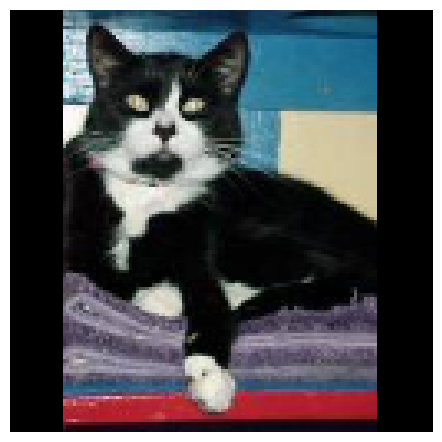

In [16]:
INDEX = 746

image = X_test[INDEX]
cat = y_test[INDEX]
pred = int(round(y_pred[INDEX][0], 0))

print('predicted category:', CATEGORIES[pred])
view_data(image, cat)